In [131]:
import json
import datetime
import altair as alt
import pandas as pd
import numpy as np
import os

hits = [
'2018-08-10_00-00-00', #0
'2018-08-29_11_32_44',
'2018-08-29_22-54-16', #2
'2018-09-05_21-38-43',
'2018-09-07_11-34-48',
'2018-09-08_09-41-18',
'2018-09-09_10-28-14', #6
]
base = 'hits/' + hits[5]
def cd(file):
    return os.path.join(base, file)

In [132]:
def duration_plot(assignments):
    times = []
    submit_times = []
    for l in assignments:
        submit = datetime.datetime.strptime(l['SubmitTime'][:-6], "%Y-%m-%d %H:%M:%S")
        accept = datetime.datetime.strptime(l['AcceptTime'][:-6], "%Y-%m-%d %H:%M:%S")
        submit_times.append(submit)
        diff = (submit - accept).total_seconds()/60.0
        times.append({"diff": diff})
    spec = {
      "data": {"values": times},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    print('min - max: ', min(submit_times), max(submit_times))
    print('mean duration: ', np.mean(list(map(lambda d: d['diff'], times))))
    return alt.VegaLite(spec)

min - max:  2018-09-08 09:45:47 2018-09-08 13:14:14
mean duration:  9.42526666667


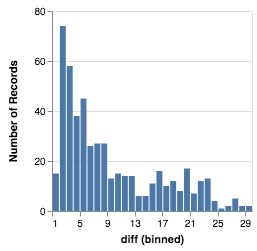

min - max:  2018-09-08 13:41:34 2018-09-08 16:11:30
mean duration:  7.62863333333


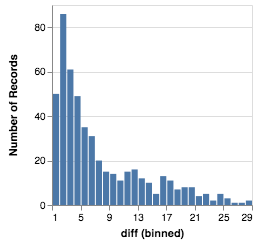

In [133]:
listener_assignments = json.load(open(cd('listener.assignments')))
speaker_assignments = json.load(open(cd('speaker.assignments')))
display(duration_plot(speaker_assignments))
display(duration_plot(listener_assignments))

In [134]:
import collections 

def by_worker(assign):
    workers = collections.defaultdict(int)
    for a in assign:
        workers[a['WorkerId']] += 1
    descending = sorted(workers.items(), key=lambda a: -a[1])
    return collections.OrderedDict(descending) 

listener_counts = by_worker(listener_assignments)
speaker_counts = by_worker(speaker_assignments)
intersection = set(speaker_counts.keys()).intersection(listener_counts.keys())

for k in intersection:
    print(k, listener_counts[k], speaker_counts[k])
print('speak: {} listener {} overlap {}'.format(len(speaker_counts), len(listener_counts), len(intersection)))

A1TVJ4HKOOIL6L 6 15
APJJ1HHD2GGFS 4 3
A3F9N2P4NUUR7S 28 23
A2R3KI7FWWGBIV 14 10
A1Y82LKWQQP90M 11 7
A38WZEK3MZXR3Q 5 19
A27K37YQZDPER6 4 18
A374STD2W8N1U8 22 37
A1T05ZAYGEPASK 2 14
A3CGA66ES1ZTKC 18 5
A3W24IE6P9O302 15 55
A98E8M4QLI9RS 12 21
ARB52L0KXB1DE 10 9
A15WCNO32MHBAF 10 4
A3TUJHF9LW3M8N 4 2
AW47H2ISJWAJC 3 8
AUI3R928P63B0 15 16
A7K6LJGDREGTT 6 7
A2VR0KBCWPY8E1 9 3
speak: 57 listener 96 overlap 19


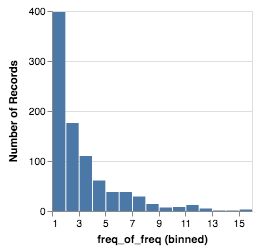

2465 901 398


In [135]:
import pandas as pd
import collections
from mturk.query_line import QueryLine

pd.set_option("display.max_rows", None)
dataf = open(cd('speaker.listener.jsonl'))

def isfloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def reduce_formula(x):
    v = x[x.index(':')+1:]
    return x[:x.index(':')] + ('number' if isfloat(v) else v)

lines = [QueryLine(l) for l in dataf.readlines()]
formulas = [l.example()['targetFormula'] for l in lines]
paths = list(map(lambda x: reduce_formula(x), formulas))
pathsset = set(paths)
pathcounter = collections.Counter(paths)
countisone = [k for k in pathcounter.keys() if pathcounter[k] == 1]
freqfreq = pathcounter.values()
spec = {
      "data": {"values": [{"freq_of_freq": v} for v in freqfreq]},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "freq_of_freq",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
chart = alt.VegaLite(spec)
display(chart)
print(len(paths), len(pathsset), len(countisone))
table = pd.DataFrame({'utterances': uniques})
open('visualize.html', 'w').write(table.to_html())

def to_html(spec):
    return alt.utils.html.spec_to_html(spec, 'vega-lite', '3', '3', '2')

# open('visualize.html', 'w').write(to_html(spec))

In [136]:
import mturk.process_listener as pl 
examples = [QueryLine(line.strip()) for line in open(cd('speaker.jsonl'), 'r').readlines()]
listener_log = [QueryLine(line.strip()) for line in open(cd('listener.raw.jsonl'), 'r').readlines()]
# adds annotations
pl.process_listener(examples, listener_log)
speakers, listeners = pl.aggregate_turker(examples)

def q2row(l: QueryLine):
    return {'utterance': l.utterance(), 'workerId': l.worker_id(), 'targetFormula': l.example()['targetFormula']} 

def speaker2row(id, l: dict):
    return {'WorkerId': id, 'stats': l['stats'],
            'utts': l['utterances'], 'listeners': len(l['listeners'])}

table = pd.DataFrame.from_records([speaker2row(k, v) for k,v in speakers.items()])
table.sort_values(by=['WorkerId'])
display(table)
open('visualize.html', 'w').write(table.to_html())

number of listener pick_or_skip 4655


,WorkerId,listeners,stats,utts
0,AC5UD8N187QD6,36,"{'correct': 30, 'wrong': 5, 'skip': 1}","[invert items on y axis, convert bars to circl..."
1,AUI3R928P63B0,129,"{'correct': 114, 'wrong': 12, 'skip': 3}","[Delete Y axis label. , Change the position of..."
2,ASL76QYDI0QLK,122,"{'correct': 104, 'wrong': 15, 'skip': 3}","[back ground colour is missing, the graph plot..."
3,A1DB55ZHE7ENEH,34,"{'correct': 29, 'wrong': 5, 'skip': 0}","[move labels on the x axis up one row, make th..."
4,A1P7ZED14W8QPK,53,"{'correct': 37, 'wrong': 9, 'skip': 7}","[Make the plot bigger and align the keys, Move..."
5,A1T05ZAYGEPASK,116,"{'correct': 86, 'wrong': 19, 'skip': 11}","[x label merge with the x intervals, series fo..."
6,A2VR0KBCWPY8E1,29,"{'correct': 24, 'wrong': 2, 'skip': 3}","[Set y-axis max to 60 and x-axis max to 275, C..."
7,A1TVJ4HKOOIL6L,134,"{'correct': 92, 'wrong': 18, 'skip': 24}",[There is no graph inside the chart in new and...
8,A1TMTGRETDPYK,18,"{'correct': 14, 'wrong': 3, 'skip': 1}",[Bring the price numbers slightly higher than ...
9,A15WCNO32MHBAF,29,"{'correct': 24, 'wrong': 4, 'skip': 1}","[Shift legend to align-left inside graph, Remo..."


11270